# OOPython

Задача 6. Численное решение УрЧП.

Борисов Дмитрий, 373гр.

### 1. Создать иерархию классов, реализующих численное интегрирование однородного уравнения теплопроводности с использованием следующих приближенных методов:
* явный метод Эйлера 1-го порядка точности
* метод Эйлера с пересчетом 2-го порядка точности
* метод Рунге-Кутты 3-го порядка точности
* метод Рунге-Кутты 4-го порядка точности

In [1]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class RightHandSide:
    def __init__(self, kappa, numSpacePoints, spaceStep, leftBondaryCondition, rightBondaryCondition):
        self._leftBondaryCondition, self._rightBondaryCondition = leftBondaryCondition, rightBondaryCondition
        self._coeff = kappa / spaceStep**2

        self._A = np.zeros((numSpacePoints - 2, numSpacePoints - 2))
        for i in range(numSpacePoints - 2):
            for j in range(numSpacePoints - 2):
                if abs(i - j) == 1:
                    self._A[i][j] = 1. * self._coeff
                elif i == j:
                    self._A[i][j] = -2. * self._coeff

    def GetBondaryConditions(self):
        return self._leftBondaryCondition, self._rightBondaryCondition

    def __call__(self, time, U):
        B = self._A.dot(U)
        B[0] += self._coeff * self._leftBondaryCondition(time)
        B[-1] += self._coeff * self._rightBondaryCondition(time)
        return B

In [3]:
class AbstractOneStepODESolver:
    _name = 'Abstract ODE solver'
    
    def __init__(self):
        print 'A %s solver initialized.' % self.__class__.__name__  
        
    def GetMethodName(self):
        return self._name
    
    def SetInitialCondition(self, InitialCondition):
        self._initialCondition = InitialCondition
        
    def _SetBondaryConditions(self):
        self._leftBondaryCondition, self._rightBondaryCondition = self._RightHandSide.GetBondaryConditions()
     
    def SetRightHandSide(self, RightHandSide):
        self._RightHandSide = RightHandSide
        self._SetBondaryConditions()
    
    def SetGrid(self, numSpacePoints, numTimePoints, spaceStep, timeStep):
        self._numSpacePoints, self._numTimePoints = numSpacePoints, numTimePoints
        self._spaceStep, self._timeStep = spaceStep, timeStep
        self._solutionArray = np.zeros((self._numTimePoints, self._numSpacePoints))
        self._spaceArray = np.linspace(0., self._spaceStep * (self._numSpacePoints - 1), self._numSpacePoints)

    def _AdvanceNextStep(self):
        raise NotImplementedError       

    def Solve(self):  
        self._timeCounter = 0
        for i in range(self._numSpacePoints):
            self._solutionArray[0][i] = self._initialCondition(i * self._spaceStep)

        for t in range(1, self._numTimePoints):            
            self._solutionArray[t][1:-1] = self._AdvanceNextStep()
            self._solutionArray[t][0] = self._leftBondaryCondition(t * self._timeStep)
            self._solutionArray[t][-1] = self._rightBondaryCondition(t * self._timeStep)
            self._timeCounter += 1

        return self._solutionArray
    
    def PlotSolution(self):
        plt.figure(figsize = (10, 10))
        plt.plot(self._spaceArray, self._solutionArray[self._timeCounter], '-', linewidth=4)
        plt.grid('on')
        plt.title('\nSolution via %s at T = %f\n' % (self._name, self._timeCounter * self._timeStep), fontsize=18)
        plt.xlabel('x')
        plt.ylabel('Heat')
        plt.show()

In [4]:
class SolveODEEuler1stOrder(AbstractOneStepODESolver):
    _name = '1st order Euler ODE solver'
    def _AdvanceNextStep(self):
        f, dt = self._RightHandSide, self._timeStep

        uOld = self._solutionArray[self._timeCounter][1:-1]
        uNew = uOld + dt * f(self._timeCounter * dt, uOld) 
        return uNew

class SolveODEModifiedEuler2ndOrder(AbstractOneStepODESolver):
    _name = '2nd order Modified Euler ODE solver'
    def _AdvanceNextStep(self):
        f, dt = self._RightHandSide, self._timeStep

        uOld = self._solutionArray[self._timeCounter][1:-1]
        uStar = uOld + dt * f(self._timeCounter * dt, uOld)
        uNew = uOld + dt / 2. * (f(self._timeCounter * dt, uOld) + f((self._timeCounter + 1) * dt, uStar))
        return uNew
    
class SolveODERungeKutta3(AbstractOneStepODESolver):
    _name = '3rd order Runge-Kutta ODE solver'
    def _AdvanceNextStep(self):
        f, dt = self._RightHandSide, self._timeStep
        oldTime = self._timeCounter * dt
        uOld = self._solutionArray[self._timeCounter][1:-1]        
        
        k1 = f(oldTime, uOld)
        k2 = f(oldTime + dt / 2., uOld + k1 * dt / 2.)
        k3 = f(oldTime + dt, uOld + (2 * k2 - k1) * dt)      
        uNew = uOld + (k1 + 4. * k2 + k3) * dt / 6.   
        return uNew
    
class SolveODERungeKutta4(AbstractOneStepODESolver):
    _name = '4th order Runge-Kutta ODE solver'
    def _AdvanceNextStep(self):
        f, dt = self._RightHandSide, self._timeStep
        oldTime = self._timeCounter * dt
        uOld = self._solutionArray[self._timeCounter][1:-1]        

        k1 = f(oldTime, uOld)
        k2 = f(oldTime + dt / 2., uOld + k1 * dt / 2.)
        k3 = f(oldTime + dt / 2., uOld + k2 * dt / 2.)
        k4 = f(oldTime + dt, uOld + k3 * dt)       
        uNew = uOld + (k1 + 2. * k2 + 2. * k3 + k4) * dt / 6.
        return uNew

### 2. Тестирование работы классов: 

In [5]:
listOfSolvers = [SolveODEEuler1stOrder(), SolveODEModifiedEuler2ndOrder(),\
                 SolveODERungeKutta3(), SolveODERungeKutta4()]

A SolveODEEuler1stOrder solver initialized.
A SolveODEModifiedEuler2ndOrder solver initialized.
A SolveODERungeKutta3 solver initialized.
A SolveODERungeKutta4 solver initialized.


In [6]:
def initialCondition(x):
    if x >= 0.4 and x <= 0.6:
        return 1
    else:
        return 0
    
def leftBondaryCondition(t):
    return 0.

def rightBondaryCondition(t):
    return 0.

def setSpaceAndTimeProperties(i, kappa, T):
    spaceStep = 1. / (100 * 2**(i - 2))
    timeStep = spaceStep**2 / (200 * kappa)
    numSpacePoints = int(ceil(1. / spaceStep)) + 1
    numTimePoints = int(ceil(T / timeStep)) + 1
    
    return spaceStep, timeStep, numSpacePoints, numTimePoints

kappa = 0.1
T = 0.04

#### В качестве аналитического решения взять численное, полученное при помощи явного метода Эйлера при значениях шагов h4, t4


Analytic Solution:


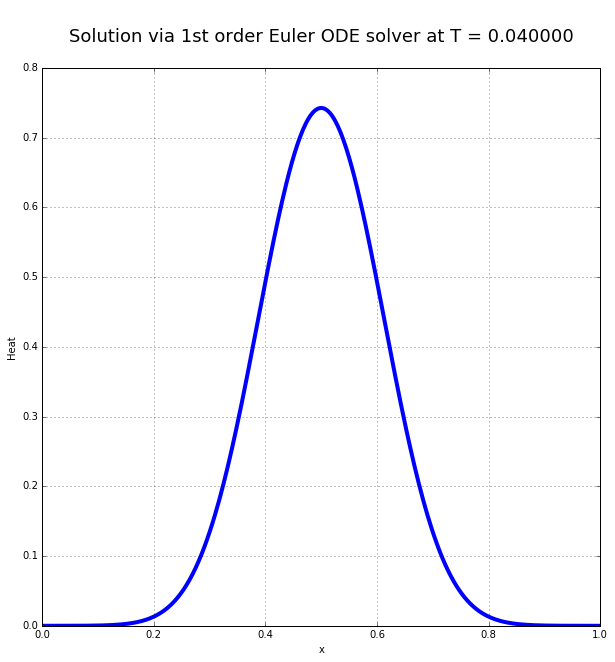

In [7]:
spaceStep, timeStep, numSpacePoints, numTimePoints = setSpaceAndTimeProperties(4, kappa, T)
analyticSolutionSpaceStep = spaceStep

solver = listOfSolvers[0] #SolveODEEuler1stOrder
solver.SetInitialCondition(initialCondition)
solver.SetGrid(numSpacePoints, numTimePoints, spaceStep, timeStep)
solver.SetRightHandSide(RightHandSide(kappa, numSpacePoints, spaceStep,\
                                              leftBondaryCondition, rightBondaryCondition))  
analyticSolution = solver.Solve()
print "\nAnalytic Solution:"
solver.PlotSolution()

### Численное интегрирование уравнения теплопроводности, для которого поставлена смешанная задача.

#### Построить графики:
* численных решений, полученных каждым из методов, при значениях шагов h_3, t_3 в момент времени T= 0.04:

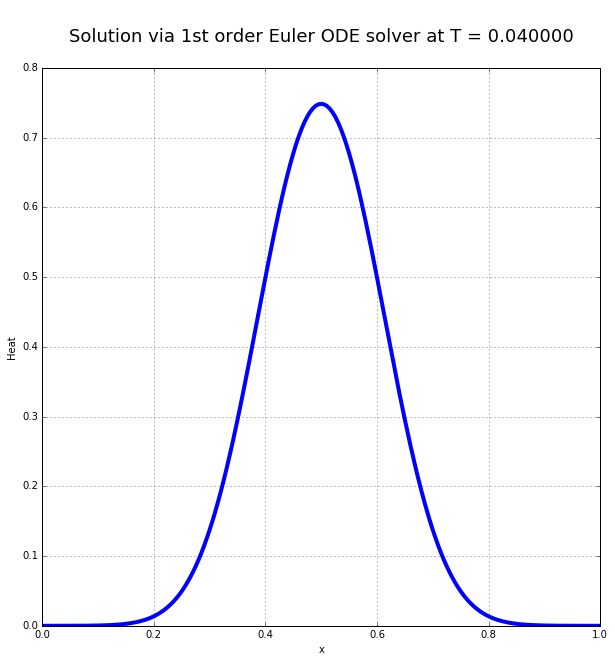

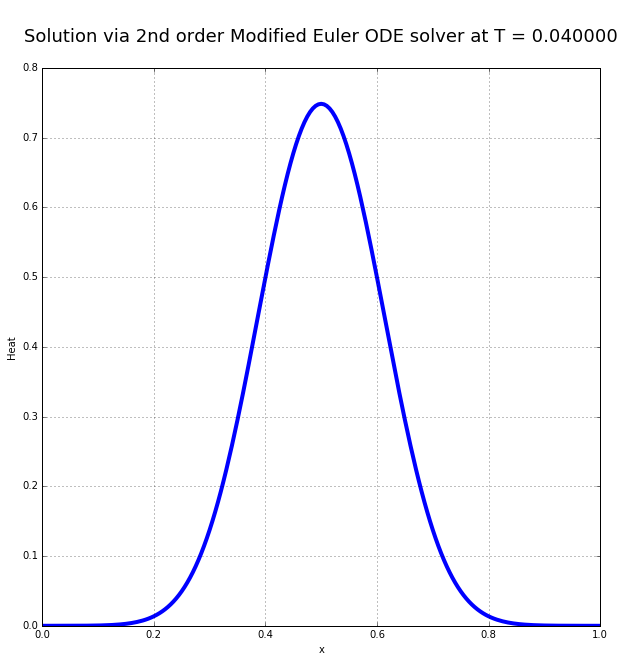

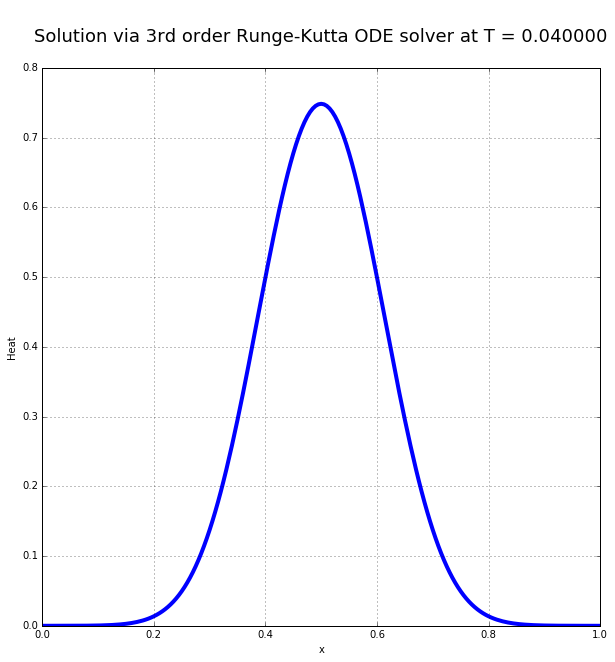

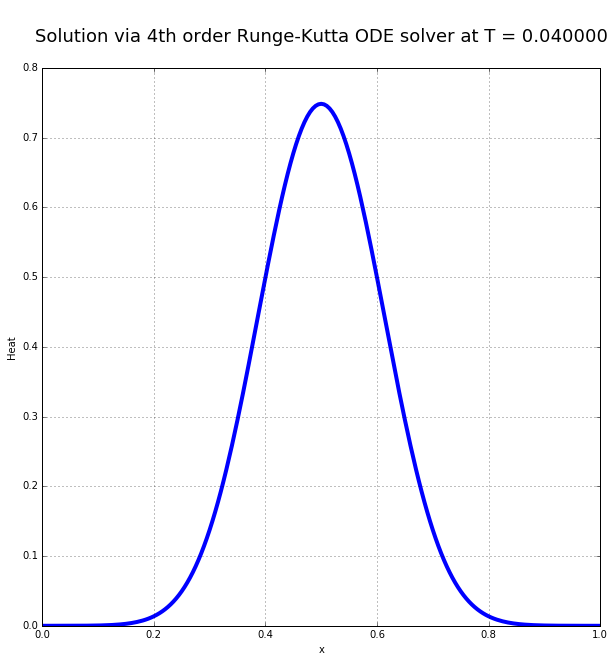

In [8]:
listOfErrors = []
namesOfMethods = []
listOfSteps = []

for solver, i in zip(listOfSolvers, range(len(listOfSolvers))):
    namesOfMethods.append(solver.GetMethodName())
    errorList = []
    solver.SetInitialCondition(initialCondition)

    for j in range(4):
        spaceStep, timeStep, numSpacePoints, numTimePoints = setSpaceAndTimeProperties(j, kappa, T)   
        if i == 0: listOfSteps.append(spaceStep)

        solver.SetGrid(numSpacePoints, numTimePoints, spaceStep, timeStep)
        solver.SetRightHandSide(RightHandSide(kappa, numSpacePoints, spaceStep,\
                                              leftBondaryCondition, rightBondaryCondition))  
        solution = solver.Solve()
        if j == 3:
            solver.PlotSolution()
          
        arrayStep = int(ceil(spaceStep / analyticSolutionSpaceStep))
        error = np.amax(np.fabs(solution[-1] - analyticSolution[-1][::arrayStep]))
        errorList.append(error)

    listOfErrors.append(errorList)

* норм погрешностей численных решений для каждого из методов в логарифмическом масштабе:

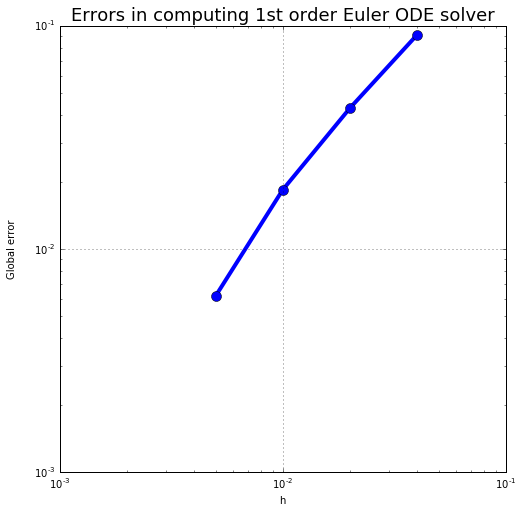

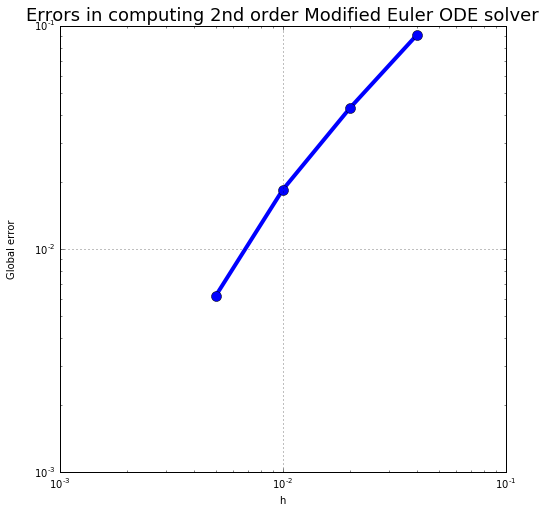

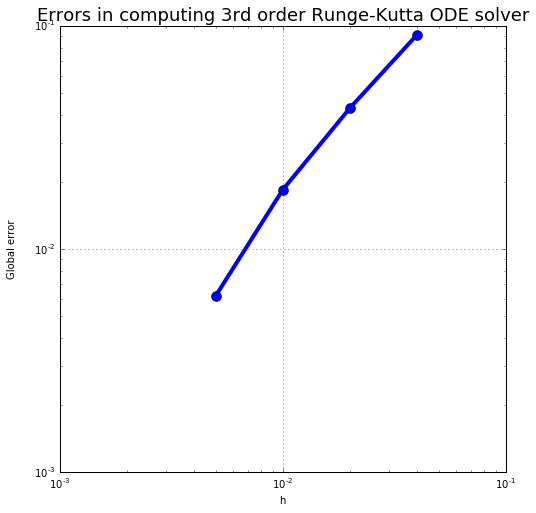

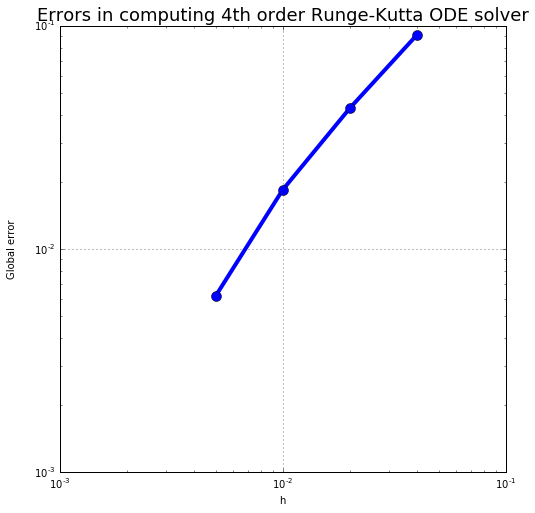

In [9]:
for name, errorList in zip(namesOfMethods, listOfErrors):
    plt.figure(figsize=(8, 8))
    plt.title('Errors in computing ' + name, fontsize=18)
    plt.xlabel('h')
    plt.ylabel('Global error\n')
    plt.grid('on')
    
    plt.loglog(listOfSteps, errorList, '-o', markersize = 10, linewidth = 4)
    plt.show()